# Where are the objects on the sea floor? Where will they go?

Hazardous objects are unidentified all over the sea floor. What are the spatial patterns that we might see when using machine learning and artificial intelligence to identify such objects? Furthermore, will these objects be buried in sediment or will they move over time? 

In [1]:
import os
import glob
import earthpy as et
import earthpy.plot as ep
import pandas as pd
import geopandas as gpd
import seaborn as sns
import matplotlib.pyplot as plt
from shapely.geometry import Polygon
from fiona.drvsupport import supported_drivers
import folium
from folium.plugins import MarkerCluster
import xarray as xr
import rioxarray as rxr
import rasterio as rio
from rasterio.plot import plotting_extent
import zipfile

# python file containing our functions
from kml_functions import read_kml, create_refined_df

In [2]:
# %load_ext pycodestyle_magic

In [3]:
# Easy pep8 checker
# %pycodestyle_on

In [4]:
# go to /earth-analytics/data directory
os.chdir(os.path.join(et.io.HOME, 'earth-analytics', 'data'))

## Generate a boundary for our study area.
### We are focusing on the coastal region of North and South Carolina.
This area was selected by the team due to availability of data on the east coast.
These bounds were selected based on the state lines and the correlated ocean space.


#### Locating objects on the coast of the Carolinas. ####
* This work will map out various objects on the sea floor off the coast of North and South Carolina.
* The state governments keep track of both artificial reefs and oyster sanctuaries. 
* There have also historically been quite a few wrecks in that area which NOAA keeps track of. 
* This notebook will combine all of the mentioned data and map it out on an interactive folium map.

In [5]:
# Create Bounding Box - North and South Carolina coastal region
box = {'geometry': [Polygon([(-77.121369, 36.541466),
                             (-70.760165, 36.541466),
                             (-71.511922, 32.087495),
                             (-79.317663, 31.036502)])]}
bbox_gdf = gpd.GeoDataFrame(box, crs='EPSG:4326')
bbox_gdf.bounds

,minx,miny,maxx,maxy
0,-79.317663,31.036502,-70.760165,36.541466


## Download artifical reef data for the Carolinas

### North Carolina
![NC Reed](img/NC_artificial_reefs.jpg)
Image Credit: North Carolina government, available at [This site](https://www.deq.nc.gov/about/divisions/marine-fisheries/public-information-and-education/coastal-fishing-information/artificial-reefs/interactive-reef-guide)
* The North Carolina Division of Marine Fisheries maintains 43 ocean artificial reef and 25 estuarine reefs. These are strategically located and designed to maximize access by anglers and divers, but also serve biological and ecological roles. 
* These reefs are in the inlets as well as off the coast.
* The estuarine reefs include specialized artificials reefs called Pyster Sanctuaries. An oyster sanctuary is an area where the harvest of oyster is prohibited. This encourages the growth of the oyster population. The related reefs are built with materials that encourage baby oysters to settle and grow. These materials are:
 * Natural oyster and clam shell
 * Class B rip-rap marl
 * Reef Balls™
 * Concrete pipes
 * Recycled crushed concrete
 * Various types of mined rock
* There were some challenges with using the `earthpy` package to download this data so there are instructions for that in the `README`. 

### South Carolina
![SC Reef](img/SC_artificial_reefs.jpg)
Image Credit: South Carolina government, available at [This site](https://www.deq.nc.gov/about/divisions/marine-fisheries/public-information-and-education/coastal-fishing-information/artificial-reefs/interactive-reef-guide)

* In South Carolina the reefs are managed by the Department of Natural Resources. 
* A lot of funding comes from the Saltwater Recreational Fishing License Program.
* There are over 40 offshore artificial reefs in addition to the inshore reefs.
* Similar to North Carolina fishing and diving are allowed on the reefs. 

Reefs help increase fish populations so there is motivation for state governments, fisherman, and divers to create more. 


In [6]:
# NOTE: Download instructions are in the README for this.
nc_reef_kml_pth = os.path.join(
   et.io.HOME, 'earth-analytics', 'data', 'earthpy-downloads',
   'Reef_Material.kml')

sc_reef_kml_pth = os.path.join(
   et.io.HOME, 'earth-analytics', 'data', 'earthpy-downloads',
   'ArtReef2021__GE', 'ArtReef2021.kml')

if not os.path.exists(sc_reef_kml_pth):
    et.data.get_data(
        url=('https://www.dnr.sc.gov/marine/reef/ArtReef2021__GE.zip'))

## Download ENC and AWOIS wrecks and obstruction data

The Automated Wreck and Obstruction Information System contains information on various obstructions in coastal U.S waters. This database provides us automated information as well as information directly recieved from the electronic nautical charts (ENC's). While the AWOIS tracks a variety of objects, ENC's specifically track shipwrecks. These combined make for comprehensive information on over 13,000 wrecks and 6,000 other obstructions off the coastal United States.

This database contains information on a wide variety of objects, from shipwrecks, to submerged concrete, granite, and more. This information helps provide safe passage through coastal waters and has been pivotal nautical information since it's implementation by the National Ocean Service in 1981. Based on the data within our bounding box, there are staggering 533 ENC Wrecks and 72 AWOIS Obstructions in the region.

![AWOIS](img/AWOIS.png)
Image Credit: NOAA Office of Coast Survery Blog available [here](https://noaacoastsurvey.wordpress.com/tag/noaa-enc/#:~:text=As%20the%20official%20chart%20data,much%20more%20comprehensive%20than%20AWOIS)


In [7]:
# Get datasets from the Wrecks and Obstructions Database
ENC_wrecks_kml_pth = os.path.join(
    et.io.HOME, 'earth-analytics', 'data', 'earthpy-downloads',
    'ENC_Wrecks.kml')
AWOIS_wrecks_kml_pth = os.path.join(
    et.io.HOME, 'earth-analytics', 'data', 'earthpy-downloads',
    'AWOIS_Obstructions.kml')

# Caching
if not os.path.exists(ENC_wrecks_kml_pth):
    et.data.get_data(
        url=("https://wrecks.nauticalcharts.noaa.gov/"
             "downloads/ENC_Wrecks.kml"))
if not os.path.exists(AWOIS_wrecks_kml_pth):
    et.data.get_data(
        url="https://wrecks.nauticalcharts.noaa.gov/"
            "downloads/AWOIS_Obstructions.kml")

## Functions for processing the downloaded data.

The `read_kml` function allows us to easiy read in datasets that are KML's and turn them into GeoPandas dataframes. In this process we are also able to clip the data using the bounding box geodataframe we created for the study area (`bbox_gdf`). 

Once we get the geodataframe we want to put our data into a standard Pandas DataFrame with matching headers so that we can combine all our data from various sources that may not initially have all the same headers.  This is what the `create_refined_df` function was built for. It pulls the latitude and longitude from the geometry column of the geodataframe and separates them into their own columns. 

Note: We did create columns for `size` and `description`, but since those are not as uniform to pull they are handled on an individual basis for each data source. Additionally, our geometry method here works best for `POINT` geometry which is why the North Carolina Artificial reef dataset is handled differently since it contains `POLYGON` and `MULTIPOLYGON` geometries.

Text(0.5, 1.0, 'ENC Wrecks')

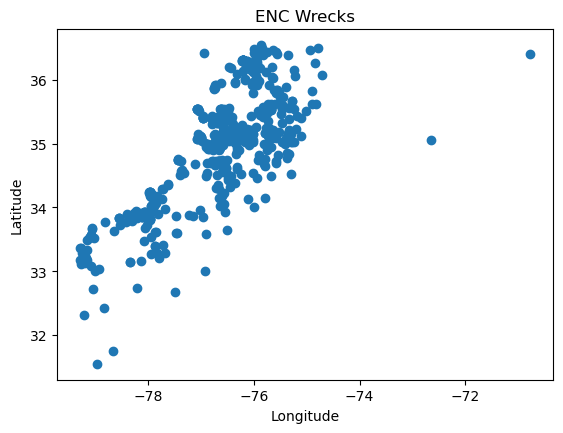

In [8]:
# ENC Wrecks gdf
ENC_gdf = read_kml(ENC_wrecks_kml_pth)
ax = ENC_gdf.plot()
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
ax.set_title('ENC Wrecks')

In [9]:
# Convert ENC gdf to refined df
ENC_df = create_refined_df(ENC_gdf)
ENC_df['description'] = 'ENC Wreck'
ENC_df

,lat,lon,size,description
0,33.922513,-78.068892,NaN,ENC Wreck
1,33.891817,-78.059333,NaN,ENC Wreck
2,33.912611,-78.013105,NaN,ENC Wreck
3,34.248807,-77.972304,NaN,ENC Wreck
4,33.854067,-78.110763,NaN,ENC Wreck
...,...,...,...,...
528,33.138060,-78.346580,NaN,ENC Wreck
529,33.405189,-77.712152,NaN,ENC Wreck
530,33.393833,-77.878381,NaN,ENC Wreck
531,33.283805,-77.831113,NaN,ENC Wreck


Text(0.5, 1.0, 'AWOIS Obstructions')

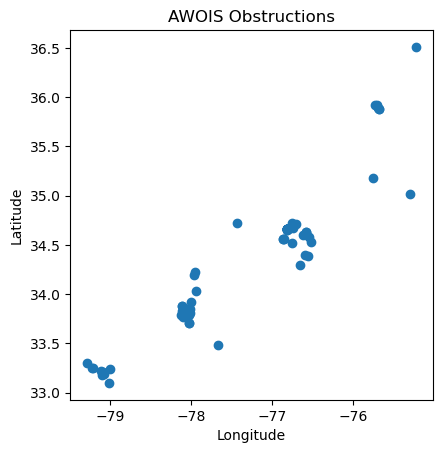

In [10]:
# AWOIS Wrecks/obstrctions gdf
AWOIS_gdf = read_kml(AWOIS_wrecks_kml_pth)

# plot
ax1 = AWOIS_gdf.plot()
ax1.set_xlabel("Longitude")
ax1.set_ylabel("Latitude")
ax1.set_title("AWOIS Obstructions")

In [11]:
# AWOIS df
AWOIS_df = create_refined_df(AWOIS_gdf)
AWOIS_df['description'] = 'AWOIS Obstruction'
AWOIS_df

,lat,lon,size,description
0,33.099722,-79.013611,NaN,AWOIS Obstruction
1,33.183092,-79.093350,NaN,AWOIS Obstruction
2,33.196047,-79.090931,NaN,AWOIS Obstruction
3,33.240278,-79.000556,NaN,AWOIS Obstruction
4,34.628000,-76.574953,NaN,AWOIS Obstruction
...,...,...,...,...
67,34.718636,-77.428544,NaN,AWOIS Obstruction
68,36.509286,-75.217386,NaN,AWOIS Obstruction
69,34.298500,-76.651314,NaN,AWOIS Obstruction
70,34.525164,-76.511586,NaN,AWOIS Obstruction


In [12]:
# North Carolina reef material/oyster sanctuaries
# Cannot find file? 
nc_reef_gdf = read_kml(nc_reef_kml_pth)
nc_reef_gdf

type: /home/jovyan/earth-analytics/data/earthpy-downloads/Reef_Material.kml: No such file or directory

In [15]:
# Create North Carolina reef dataframe
nc_reef_df = pd.DataFrame(columns=[
    'lat', 'lon', 'size', 'description'])

nc_reef_df['lon'] = nc_reef_gdf.geometry.centroid.x
nc_reef_df['lat'] = nc_reef_gdf.geometry.centroid.y
nc_reef_df['description'] = nc_reef_gdf.Name
nc_reef_df

type: name 'nc_reef_gdf' is not defined

Text(0.5, 1.0, 'South Carolina Artificial Reefs')

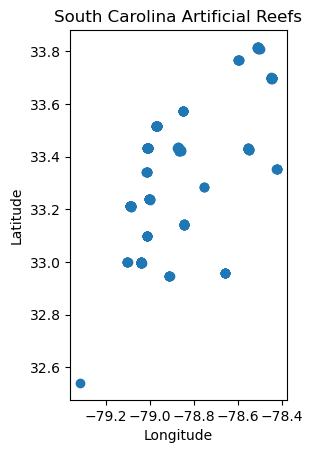

In [16]:
sc_reef_gdf = read_kml(sc_reef_kml_pth)

# plot
ax2 = sc_reef_gdf.plot()
ax2.set_xlabel("Longitude")
ax2.set_ylabel("Latitude")
ax2.set_title("South Carolina Artificial Reefs")

In [17]:
# South Carolina Reef df
sc_reef_df = create_refined_df(sc_reef_gdf)
sc_reef_df['description'] = sc_reef_gdf.Name
sc_reef_df

,lat,lon,size,description
0,33.426033,-78.865233,NaN,10 Mile APCs
1,33.426067,-78.864950,NaN,10 Mile APCs
2,33.426350,-78.864933,NaN,10 Mile APCs
3,33.426400,-78.865250,NaN,10 Mile APCs
4,33.426550,-78.865783,NaN,10 Mile APCs
...,...,...,...,...
278,33.141667,-78.845267,NaN,W. Upchurch Cones
279,33.141917,-78.845267,NaN,W. Upchurch Cones
280,33.142417,-78.844167,NaN,W. Upchurch Pipe
281,33.516833,-78.970167,NaN,Win Perry


In [18]:
# Concatonate the dataframes
total_df = pd.concat([nc_reef_df, sc_reef_df, AWOIS_df, ENC_df])
total_df

,lat,lon,size,description
0,33.426033,-78.865233,NaN,10 Mile APCs
1,33.426067,-78.864950,NaN,10 Mile APCs
2,33.426350,-78.864933,NaN,10 Mile APCs
3,33.426400,-78.865250,NaN,10 Mile APCs
4,33.426550,-78.865783,NaN,10 Mile APCs
...,...,...,...,...
528,33.138060,-78.346580,NaN,ENC Wreck
529,33.405189,-77.712152,NaN,ENC Wreck
530,33.393833,-77.878381,NaN,ENC Wreck
531,33.283805,-77.831113,NaN,ENC Wreck


## Interactive Map
Using Folium we were able to create an interactive map using markers. These markers use the latitude and longitude from the dataframe for their locations and their description shows when you click on a marker. These markers cluster together into bigger spots to create hot spots of discarded objects as you zoom out.

In [19]:
# Map our concatonated dataframe
m = folium.Map(location=[32.087495, -71.511922], zoom_start=6)

marker_cluster = MarkerCluster().add_to(m)

for index, row in total_df.iterrows():
    folium.Marker(
        location=[row.lat, row.lon],
        popup=row.description,
        icon=folium.Icon(color="black")
    ).add_to(marker_cluster)

m

## What's Next?

Now that we have successfully identified our region of interest and downloaded multiple data sources, we will begin pahse II of our project. This step is to analyze these objects and identify what may happen to them. We will take into account the sediment type on the ocean floor, currents, depth, the density of the object and more to discern this. Machine learning - likely random forest- will help us acheive this. We will ultimately end up with a raster map that forecasts the fate of these objects over time.

In [20]:
# Night Lights Data
# unzip

os.chdir(os.path.join(
   et.io.HOME, 'seafloor-objects'))

night_lights_tif_path = os.path.join('data','night-lights', '*.tif')

night_lights_files = glob.glob(
    os.path.join('data','night-lights','*.zip'))

if not os.path.exists(night_lights_tif_path):      
    for file in night_lights_files:
        print('Unzipping:',file)

        with zipfile.ZipFile(file, 'r') as zip_ref:
            zip_ref.extractall('data/night-lights')
        
night_lights_tifs =  [f for f in glob.glob(
    os.path.join('data','night-lights','*.tif'))]

print(night_lights_tifs)

Unzipping: data/night-lights/VBD_npp_20200101-20201231_usa-e_v23.zip
Unzipping: data/night-lights/VBD_npp_20190101-20191231_usa-e_v23.zip
Unzipping: data/night-lights/VBD_npp_20180101-20181231_usa-e_v23.zip
['data/night-lights/VBD_npp_20190101-20191231_usa-e_pc_v23_c202006191500.cvg.tif', 'data/night-lights/VBD_npp_20200101-20201231_usa-e_qf1-2-3-8-10-pc_v23_c202103291200.pct_detect.tif', 'data/night-lights/VBD_npp_20180101-20181231_usa-e_qf1-2-3-8-10-pc_v23_c201902201100.pct_detect.tif', 'data/night-lights/VBD_npp_20190101-20191231_usa-e_qf1-2-3-8-10-pc_v23_c202006191500.n_detect.tif', 'data/night-lights/VBD_npp_20190101-20191231_usa-e_qf1-2-3-8-10-pc_v23_c202006191500.avg_rade9.tif', 'data/night-lights/VBD_npp_20190101-20191231_usa-e_qf1-2-3-8-10-pc_v23_c202006191500.pct_detect.tif', 'data/night-lights/VBD_npp_20200101-20201231_usa-e_qf1-2-3-8-10-pc_v23_c202103291200.avg_rade9.tif', 'data/night-lights/VBD_npp_20180101-20181231_usa-e_qf1-2-3-8-10-pc_v23_c201902201100.avg_rade9.tif', '

In [21]:
night_lights_1 = rxr.open_rasterio(night_lights_tifs[0], masked=True)
night_lights_1.rio.bounds()

(-81.50208333335, 30.497916514649997, -65.49791653865, 49.50208333335)

In [22]:
def read_tifs(path):
    # not sure
    test = rxr.open_rasterio(path, masked=True)
    print("The crs of your data is:", test.rio.crs)
    print("The nodatavalue of your data is:", test.rio.nodata)
    print("The shape of your data is:", test.shape)
    print("The spatial resolution for your data is:", test.rio.resolution())
    print("The metadata for your data is:", test.attrs)
    return None

In [23]:
read_tifs(night_lights_tifs[2])

The crs of your data is: EPSG:4326
The nodatavalue of your data is: None
The shape of your data is: (1, 4561, 3841)
The spatial resolution for your data is: (0.0041666667, -0.0041666667)
The metadata for your data is: {'AREA_OR_POINT': 'Area', 'TIFFTAG_DATETIME': '2019:02:22 12:00:34', 'TIFFTAG_DOCUMENTNAME': './VBD_npp_20180101-20181231_usa-e_qf1-2-3-8-10-pc_v23_c201902201100.pct_detect.tif', 'TIFFTAG_IMAGEDESCRIPTION': 'IDL TIFF file', 'TIFFTAG_RESOLUTIONUNIT': '2 (pixels/inch)', 'TIFFTAG_SOFTWARE': 'IDL 8.5.1, Exelis Visual Information Solutions, Inc., a subsidiary of Harris Corporation.', 'TIFFTAG_XRESOLUTION': 100, 'TIFFTAG_YRESOLUTION': 100, 'scale_factor': 1.0, 'add_offset': 0.0}


In [24]:
# Create a list comprehension to get the information on all the tifs
info = [read_tifs(i) for i in night_lights_tifs]
info

The crs of your data is: EPSG:4326
The nodatavalue of your data is: None
The shape of your data is: (1, 4561, 3841)
The spatial resolution for your data is: (0.0041666667, -0.0041666667)
The metadata for your data is: {'AREA_OR_POINT': 'Area', 'TIFFTAG_DATETIME': '2020:06:22 07:22:18', 'TIFFTAG_DOCUMENTNAME': './VBD_npp_20190101-20191231_usa-e_pc_v23_c202006191500.cvg.tif', 'TIFFTAG_IMAGEDESCRIPTION': 'IDL TIFF file', 'TIFFTAG_RESOLUTIONUNIT': '2 (pixels/inch)', 'TIFFTAG_SOFTWARE': 'IDL 8.7.2, Harris Geospatial Solutions, Inc.', 'TIFFTAG_XRESOLUTION': 100, 'TIFFTAG_YRESOLUTION': 100, 'scale_factor': 1.0, 'add_offset': 0.0}
The crs of your data is: EPSG:4326
The nodatavalue of your data is: None
The shape of your data is: (1, 4561, 3841)
The spatial resolution for your data is: (0.0041666667, -0.0041666667)
The metadata for your data is: {'AREA_OR_POINT': 'Area', 'TIFFTAG_DATETIME': '2021:03:29 23:24:31', 'TIFFTAG_DOCUMENTNAME': './VBD_npp_20200101-20201231_usa-e_qf1-2-3-8-10-pc_v23_c20

[None, None, None, None, None, None, None, None, None, None, None, None]

In [25]:
# import rasterio
# with rasterio.open(night_lights_tifs[0]) as raster:
#     image = raster.read(1)
#     crs = raster.crs
#     list_pop = [
#         {'cell_pop': value, 'geometry': raster.shape}
#         for i, (shape, value) 
#         in enumerate(shape(image, connectivity=0, transform=raster.transform))
#         if value > raster.nodata]
    
    
# df = gpd.GeoDataFrame(list_pop, crs=crs).to_crs(epsg=4326)
# df.plot()

In [26]:
# Open TIF and read it in array
night_light_test = rxr.open_rasterio(night_lights_tifs[-4], masked=True).squeeze()
night_lights = night_light_test.where(night_light_test>0)

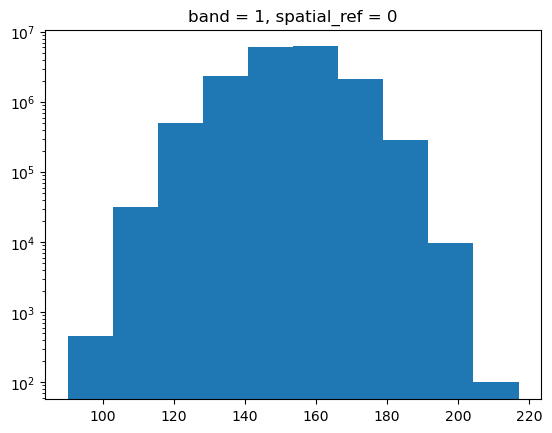

type: name 'night_light_0' is not defined

In [27]:
# Plot using earthpy
night_lights.plot.hist(yscale="log")
plt.show()
print("the minimum raster value is: ", night_light_0.min())
print("the maximum raster value is: ", night_light_0.max())

In [28]:
night_lights_df = night_lights.to_dataframe("night_lights").dropna()
night_lights_df

band  spatial_ref  night_lights
y    x                                          
49.5 -81.500000     1            0         134.0
     -81.495833     1            0         115.0
     -81.491667     1            0         137.0
     -81.487500     1            0         133.0
     -81.483333     1            0         121.0
...               ...          ...           ...
30.5 -65.516667     1            0         148.0
     -65.512500     1            0         178.0
     -65.508333     1            0         149.0
     -65.504167     1            0         180.0
     -65.500000     1            0         158.0

[17518801 rows x 3 columns]

In [29]:
# This may be obsolete as we can convert our .asc's into .tif's in QGIS and use them with our TIF work above. 
# Then all of our data will be in tiff or kml

# Here i put the data in the jupyter notebook since users 
# cannot download from our google drive
# DBseabed ASC files

#dbseabed_pth = os.path.join(et.io.HOME, 'seafloor-objects', 'data',
 #   'ea-an_codaGVL_idw3d_Proj.asc')

#if os.path.exists(dbseabed_pth):
 #   print(dbseabed_pth)
    
# A currents and wave asc
#cw_pth = os.path.join(
 #   et.io.HOME,'seafloor-objects', 'data', 'currents-and-waves',
  #  'ea-an_awWw3_Proj.asc')

#if os.path.exists(cw_pth):
 #   print(cw_pth)

In [30]:
# MAke this a function- turning ASC to csv
#read_file = pd.read_csv(dbseabed_pth)
#csv_1 = read_file.to_csv('data/test.csv', index=None)

#dbseabed_df = pd.read_csv('data/test.csv')
#dbseabed_df

In [31]:
#dbseabed_csv_pth = os.path.join('data','test.csv')

#if os.path.exists(dbseabed_csv_pth):
 #   print(dbseabed_csv_pth)

In [32]:
#read_file = pd.read_csv (cw_pth)
#read_file.to_csv ('data/currents-and-waves/csvtest.csv', index=None)

#cw_df = pd.read_csv('data/currents-and-waves/csvtest.csv')
#cw_df.info()

In [33]:
# SEE below for a better option to change all of our .asc's to tifs.

#fiona.drvsupport.supported_drivers['CSV'] = 'raw' 

# # Read in the CSV and trim it to north and south carolina- have not figured this out yet
#def read_csv_func(csv_fp: str):
 #    """
  #   Read in a csv file to a geopandas dataframe.
   #  Trim it to North and South Carolina.
#
 #    Inputs
  #   -------
   #  csv_fp: str
    #     filepath where CSV is located
    # bounds: 
    # Outputs:
    # --------
    # gdf: gpd.GeoDataFrame
     #"""
        
     #supported_drivers['CSV'] = 'raw'
     #gdf = gpd.read_file(csv_fp, driver='CSV', bbox=bbox_gdf)
     #return gdf


 # dbseabed gdf
#dbseabed_gdf = read_csv_func(dbseabed_csv_pth)
#ax = dbseabed_gdf.plot()
#ax.set_xlabel("Longitude")
#ax.set_ylabel("Latitude")
#ax.set_title('DBSeaBed')

In [100]:
# I uploaded our ASC's to QGIS and exported it as a geotiff there. Then I used the method we already had formulated for geotiffs. 

bathymetry_path = os.path.join(et.io.HOME, 'seafloor-objects', 'data', 'bathymetry', 'bathymetry1.tif')
bathymetry_path_2 = os.path.join(et.io.HOME, 'seafloor-objects', 'data', 'bathymetry','bathymetry2.tif')
marine_mishaps_path = os.path.join(et.io.HOME, 'seafloor-objects', 'data', 'marine_mishaps', 'marine_mishaps1.tif')
marine_mishaps_path_2 = os.path.join(et.io.HOME, 'seafloor-objects', 'data', 'marine_mishaps', 'marine_mishaps_coast.tif')
state_boating_path = os.path.join(et.io.HOME, 'seafloor-objects', 'data', 'state_boating', 'state_boating_opensea.tif')
state_boating_coast_path = os.path.join(et.io.HOME, 'seafloor-objects', 'data', 'state_boating', 'state_boating_rampsoncoast.tif')

# Open TIF and read it in array
bathymetry = rxr.open_rasterio(bathymetry_path, masked=True)
bathymetry2 = rxr.open_rasterio(bathymetry_path_2, masked=True)
bathymetry2.rio.bounds()

state_boating_opensea = rxr.open_rasterio(state_boating_path, masked=True)
state_boating_rampsoncoast = rxr.open_rasterio(state_boating_path, masked=True)
state_boating_rampsoncoast.rio.bounds()

marine_mishaps_coast = rxr.open_rasterio(marine_mishaps_path_2, masked=True)
marine_mishaps = rxr.open_rasterio(marine_mishaps_path, masked=True)
marine_mishaps.rio.bounds()

(0.0, 0.0, 645.0, 454.0)

type: 'DataArray' object has no attribute 'tif'

In [95]:
#read_tifs(bathymetry_path)
read_tifs(bathymetry_path_2)
#read_tifs(marine_mishaps)

The crs of your data is: None
The nodatavalue of your data is: nan
The shape of your data is: (1, 91, 129)
The spatial resolution for your data is: (0.050000000000000024, -0.04999999999999997)
The metadata for your data is: {'STATISTICS_MAXIMUM': 8.31, 'STATISTICS_MEAN': 5.509498086547, 'STATISTICS_MINIMUM': 1.97, 'STATISTICS_STDDEV': 1.3390008966787, 'STATISTICS_VALID_PERCENT': 57.88, 'scale_factor': 1.0, 'add_offset': 0.0}


type: 'str' object has no attribute 'to_array'

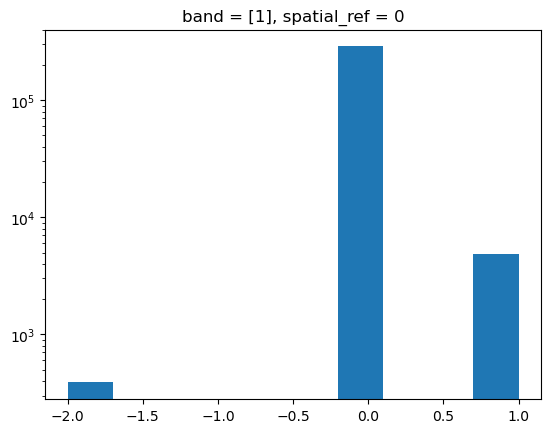

the minimum raster value is:  <xarray.DataArray ()>
array(-2.69916914)
Coordinates:
    spatial_ref  int64 0
the maximum raster value is:  <xarray.DataArray ()>
array(167.96897916)
Coordinates:
    spatial_ref  int64 0


In [59]:
# Plot using earthpy
marine_mishaps.plot.hist(yscale="log")
plt.show()
print("the minimum raster value is: ", state_boating.min())
print("the maximum raster value is: ", state_boating.max())

In [128]:
# Open TIF and read it into df
def open_tif_to_df(tif_fp):
    """

    Read in a TIF file to a data frame.

    Inputs
    ------
    tif_fp: str
        filepath where TIF is located.
    Outputs: 
    ------
    df = pd.DataFrame

    """
    
    df = tif_fp.to_dataframe
    return df


In [121]:
open_tif_to_df(bathymetry)

<bound method DataArray.to_dataframe of <xarray.DataArray (band: 1, y: 91, x: 129)>
[11739 values with dtype=float64]
Coordinates:
  * band         (band) int64 1
  * x            (x) float64 -80.92 -80.88 -80.83 ... -74.62 -74.57 -74.52
  * y            (y) float64 36.55 36.5 36.45 36.4 ... 32.2 32.15 32.1 32.05
    spatial_ref  int64 0
Attributes:
    STATISTICS_MAXIMUM:        853
    STATISTICS_MEAN:           -568.6232217395
    STATISTICS_MINIMUM:        -4706
    STATISTICS_STDDEV:         1239.9446750623
    STATISTICS_VALID_PERCENT:  100
    scale_factor:              1.0
    add_offset:                0.0>

In [122]:
open_tif_to_df(bathymetry2)

<bound method DataArray.to_dataframe of <xarray.DataArray (band: 1, y: 91, x: 129)>
[11739 values with dtype=float64]
Coordinates:
  * band         (band) int64 1
  * x            (x) float64 -80.92 -80.88 -80.83 ... -74.62 -74.57 -74.52
  * y            (y) float64 36.55 36.5 36.45 36.4 ... 32.2 32.15 32.1 32.05
    spatial_ref  int64 0
Attributes:
    STATISTICS_MAXIMUM:        8.31
    STATISTICS_MEAN:           5.509498086547
    STATISTICS_MINIMUM:        1.97
    STATISTICS_STDDEV:         1.3390008966787
    STATISTICS_VALID_PERCENT:  57.88
    scale_factor:              1.0
    add_offset:                0.0>

In [123]:
open_tif_to_df(state_boating_rampsoncoast)


<bound method DataArray.to_dataframe of <xarray.DataArray (band: 1, y: 454, x: 645)>
[292830 values with dtype=float64]
Coordinates:
  * band         (band) int64 1
  * x            (x) float64 0.5 1.5 2.5 3.5 4.5 ... 641.5 642.5 643.5 644.5
  * y            (y) float64 453.5 452.5 451.5 450.5 449.5 ... 3.5 2.5 1.5 0.5
    spatial_ref  int64 0
Attributes:
    STATISTICS_MAXIMUM:        167.96897916233
    STATISTICS_MEAN:           51.235100144709
    STATISTICS_MINIMUM:        -2.6991691433159
    STATISTICS_STDDEV:         39.662374328106
    STATISTICS_VALID_PERCENT:  55.34
    scale_factor:              1.0
    add_offset:                0.0>

In [124]:
open_tif_to_df(state_boating_opensea)

<bound method DataArray.to_dataframe of <xarray.DataArray (band: 1, y: 454, x: 645)>
[292830 values with dtype=float64]
Coordinates:
  * band         (band) int64 1
  * x            (x) float64 0.5 1.5 2.5 3.5 4.5 ... 641.5 642.5 643.5 644.5
  * y            (y) float64 453.5 452.5 451.5 450.5 449.5 ... 3.5 2.5 1.5 0.5
    spatial_ref  int64 0
Attributes:
    STATISTICS_MAXIMUM:        167.96897916233
    STATISTICS_MEAN:           51.235100144709
    STATISTICS_MINIMUM:        -2.6991691433159
    STATISTICS_STDDEV:         39.662374328106
    STATISTICS_VALID_PERCENT:  55.34
    scale_factor:              1.0
    add_offset:                0.0>

In [125]:
open_tif_to_df(marine_mishaps_coast)

<bound method DataArray.to_dataframe of <xarray.DataArray (band: 1, y: 454, x: 645)>
[292830 values with dtype=float64]
Coordinates:
  * band         (band) int64 1
  * x            (x) float64 0.5 1.5 2.5 3.5 4.5 ... 641.5 642.5 643.5 644.5
  * y            (y) float64 453.5 452.5 451.5 450.5 449.5 ... 3.5 2.5 1.5 0.5
    spatial_ref  int64 0
Attributes:
    scale_factor:  1.0
    add_offset:    0.0>

In [126]:
open_tif_to_df(marine_mishaps)

<bound method DataArray.to_dataframe of <xarray.DataArray (band: 1, y: 454, x: 645)>
[292830 values with dtype=float64]
Coordinates:
  * band         (band) int64 1
  * x            (x) float64 0.5 1.5 2.5 3.5 4.5 ... 641.5 642.5 643.5 644.5
  * y            (y) float64 453.5 452.5 451.5 450.5 449.5 ... 3.5 2.5 1.5 0.5
    spatial_ref  int64 0
Attributes:
    STATISTICS_MAXIMUM:        12.5
    STATISTICS_MEAN:           -120.57121637815
    STATISTICS_MINIMUM:        -561.33003460438
    STATISTICS_STDDEV:         111.84885731645
    STATISTICS_VALID_PERCENT:  55.34
    scale_factor:              1.0
    add_offset:                0.0>

In [141]:
training_data_path = os.path.join(et.io.HOME,'seafloor-objects', 
                                  'data', 'trainingData.csv')
if os.path.exists(training_data_path):
    print('yes')
    
training_data_df = pd.read_csv(training_data_path)

print(training_data_df)

yes
      i    j  artificialReefs  awoisWrecks  awoisObstructions  wrecksEnc  \
0     0  101              NaN          4.0                NaN        2.0   
1     0  102              NaN          2.0                NaN        NaN   
2     1   98              NaN          NaN                NaN        1.0   
3     1  102              NaN          1.0                NaN        1.0   
4     1  106              NaN          NaN                NaN        1.0   
..   ..  ...              ...          ...                ...        ...   
622  90    7             15.0          NaN                1.0        NaN   
623  90    8             21.0          NaN                NaN        1.0   
624  90    9              NaN          NaN                1.0        NaN   
625  90   10             21.0          NaN                1.0        NaN   
626  90   94              NaN          1.0                NaN        NaN   

     elevations  waveHeights    viirsA  smallBoatTraffic  aisTrafficDensity  
0    

### Citations:

Byrum, J., & Hendrix, N. (n.d.). Artificial Reefs. North Carolina Environmental Quality. Retrieved April 18, 2023, from https://www.deq.nc.gov/about/divisions/marine-fisheries/public-information-and-education/coastal-fishing-information/artificial-reefs

Coz, J. (n.d.). Artificial Reefs - Data Files. Retrieved April 29, 2023, from https://www.dnr.sc.gov/marine/reef/

National Oceanic and Atmospheric Administration (n.d.). Wrecks and Obstructions Database. U.S. Office of Coast Survey. Retrieved April 21, 2023, from https://nauticalcharts.noaa.gov/data/wrecks-and-obstructions.html



In [36]:
# Nearest neighbors helpful stuff
# https://scikit-learn.org/stable/modules/classes.html#module-sklearn.neighbors